In [1]:
import numpy as np
import pandas as pd 
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams["figure.figsize"]= 10, 5

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Preprocessing

In [2]:
bmw = pd.read_csv("bmw.csv")

In [3]:
bmw.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [4]:
bmw.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [5]:
bmw.shape

(10781, 9)

In [6]:
bmw.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

### Plot categorical features

<Figure size 720x360 with 0 Axes>

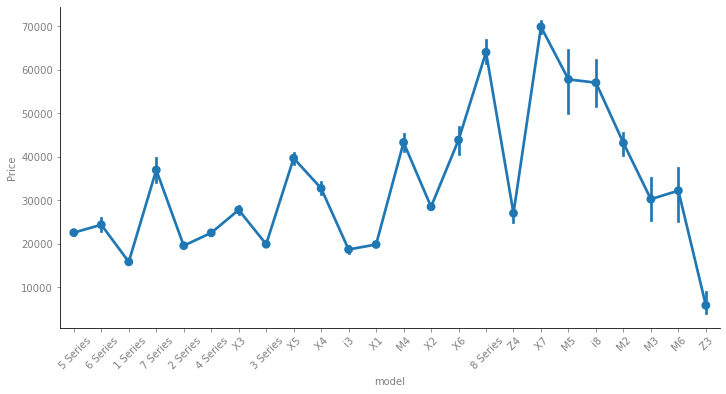

<Figure size 720x360 with 0 Axes>

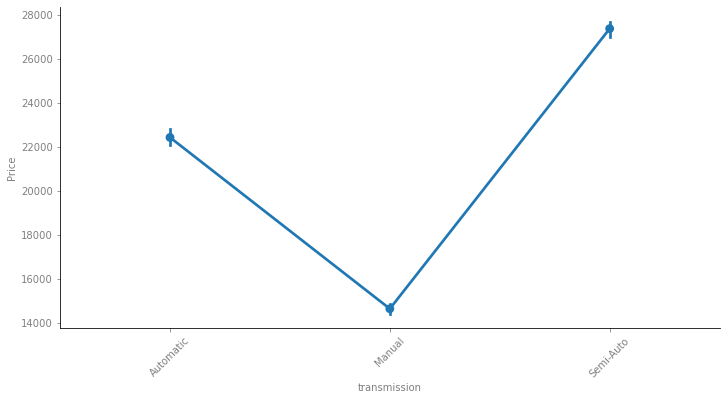

<Figure size 720x360 with 0 Axes>

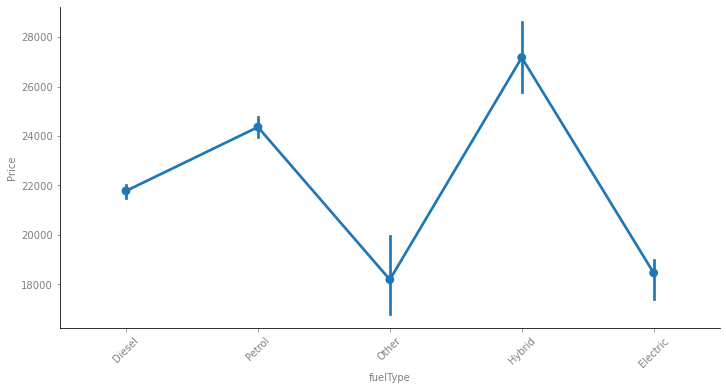

In [25]:
for i, col in enumerate(["model", "transmission", "fuelType"]):
    plt.figure(i)
    sns.catplot(x=col, y="price", data=bmw, kind="point", aspect=2)
    plt.ylabel("Price", fontdict={"color":"grey"})
    plt.xlabel(col, fontdict={"color":"grey"})
    plt.xticks(rotation= 45)
    plt.tick_params(axis='both', colors='grey')
    plt.show()

### Plot continuous features

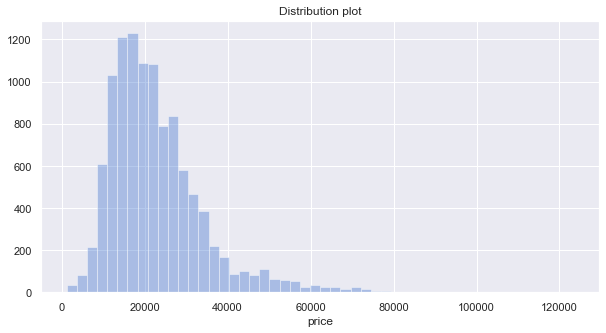

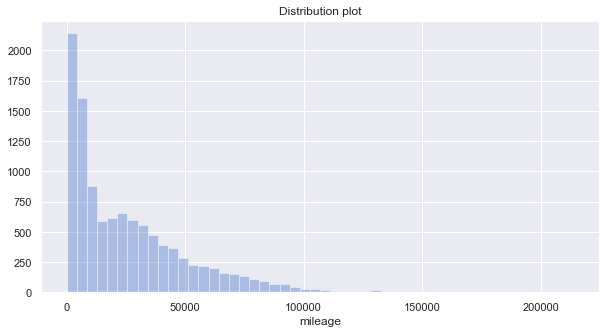

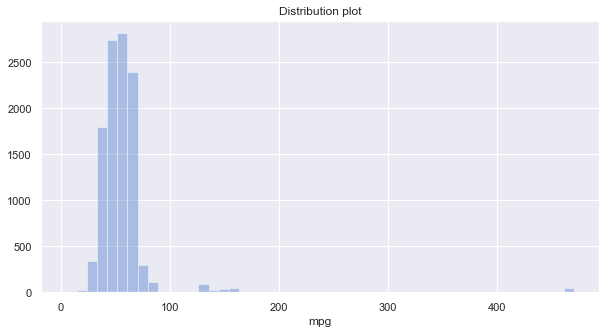

In [196]:
for i in ["price", "mileage", "mpg"]:
    sns.set(style = 'darkgrid', palette= 'muted')
    sns.distplot(bmw[i], kde=False)
    plt.title("Distribution plot")
    plt.show()

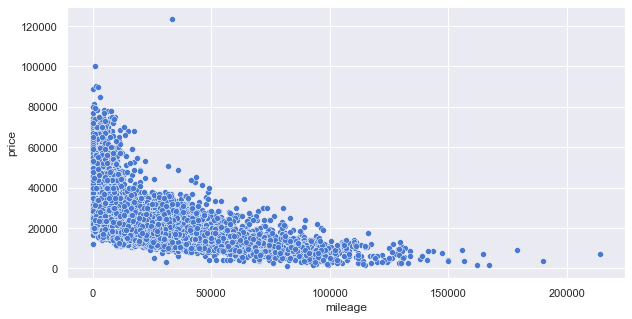

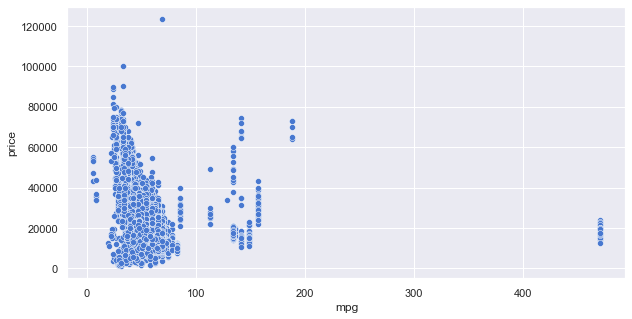

In [197]:
for i in ["mileage", "mpg"]:
    ax3 = plt.subplot(111)
    sns.set(style = 'darkgrid', palette= 'muted')
    sns.scatterplot(bmw[i], bmw["price"])
    plt.show()

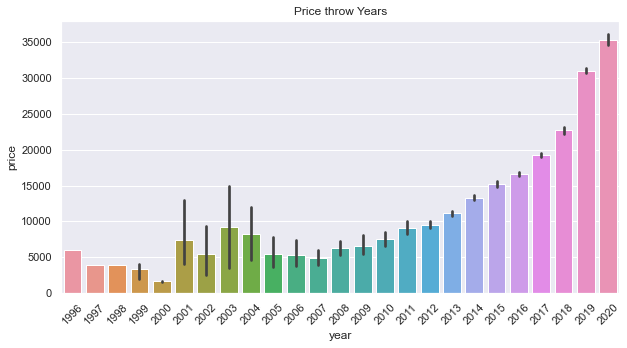

In [198]:
ax4 = sns.barplot(x='year', y='price', data=bmw, estimator=np.mean)
plt.xticks(rotation= 45)
plt.title("Price throw Years")
plt.show()

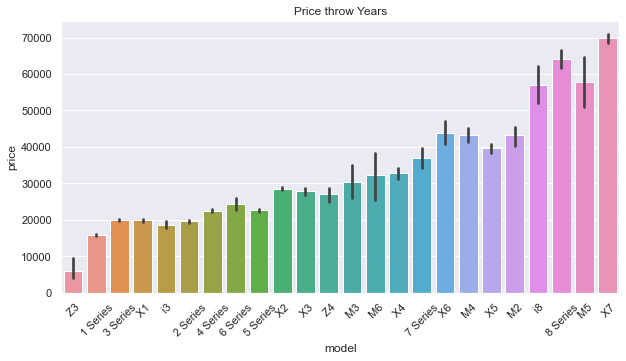

In [199]:
result = bmw.groupby(["model"])['price'].aggregate(np.median).reset_index().sort_values('price')
ax4 = sns.barplot(x='model', y='price', data=bmw,estimator=np.mean, order=result["model"])
plt.xticks(rotation= 45)
plt.title("Price throw Years")
plt.show()

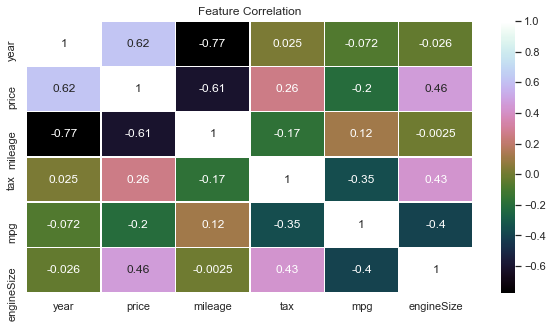

In [200]:
ax2 = sns.heatmap(bmw.corr(), annot = True, linewidths=.5, cmap="cubehelix")
plt.title("Feature Correlation")
plt.show()

### Fix the outliers and the skewness

In [231]:
bmw["price"].clip(upper=bmw["price"].quantile(0.99), inplace=True)
bmw["mileage"].clip(upper=bmw["mileage"].quantile(0.99), inplace=True)
bmw["mpg"].clip(upper=bmw["mpg"].quantile(0.99), inplace=True)
#bmw["price"] = bmw["price"].apply(lambda x: x**(0.25) )
#bmw["mileage"] = bmw["mileage"].apply(lambda x: x**(0.25) )

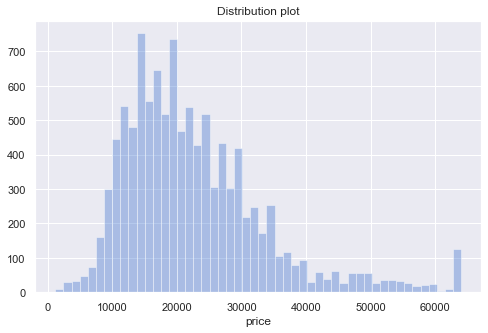

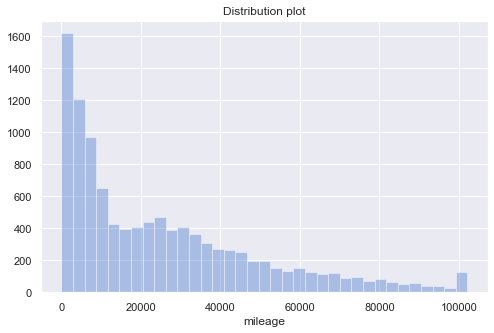

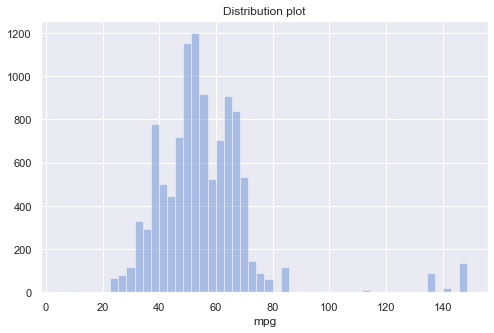

In [202]:
for i in ["price", "mileage", "mpg"]:
    plt.figure(figsize = (8, 5))
    ax1 = plt.subplot(111)
    ax1.set_title('Distribution plot')
    sns.set(style = 'darkgrid', palette= 'muted')
    sns.distplot(bmw[i], kde=False)
    plt.show()

## Encoding

In [203]:
bmw["model"] = bmw["model"].str.lstrip()
fuel_type_dict = {'Diesel': 0, 'Petrol': 1, "Hybrid": 2, "Electric": 3, "Other": 4}
model_dict = {'1 Series': 1, '2 Series': 2, "3 Series": 3, "4 Series": 4, "5 Series": 5, '6 Series': 6, '7 Series': 7, "8 Series": 8,
              'X1': 11, 'X2': 12, "X3": 13, "X4": 14, "X5": 15, 'X6': 16, 'X7': 17,
              'M2': 22, 'M3': 23, "M4": 24, "M5": 25, "M6": 26,
              'Z3': 33, 'Z4': 34,
              "i3": 43, "i8": 48}
transmission_dict = {'Manual': 0, 'Semi-Auto': 1, "Automatic": 2}
bmw["fuelType"] = bmw['fuelType'].map(fuel_type_dict)
bmw["model"] = bmw['model'].map(model_dict)
bmw["transmission"] = bmw['transmission'].map(transmission_dict)

In [204]:
bmw = bmw.sample(frac = 1) #suffle the dataset

## Train-test-split

In [205]:
features = bmw.drop(["price"], axis=1)
target = bmw["price"]

In [206]:
tr_features, x_test, tr_labels, y_test = train_test_split(features, target, test_size = 0.25, random_state = 42)
val_features, te_features, val_labels, te_labels = train_test_split(x_test, y_test, test_size = 0.33, random_state = 42)

In [207]:
for dataset in [tr_labels, val_labels, te_labels]:
    print(round(len(dataset) / len(target), 2))

0.75
0.17
0.08


## Scaling

In [208]:
tr_features = ss.fit_transform(tr_features)
val_features = ss.transform(val_features)
te_features = ss.transform(te_features)

# Machine learning- Training models- Regression

In [209]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn. model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from time import time

### Define a function that prints results

In [210]:
def print_results(results):
    print("BEST PARAMS: {}\n".format(results.best_params_))
    
    
    train_means=[]
    test_means=[]
    train_means.append(results.cv_results_["mean_train_score"])
    test_means.append(results.cv_results_["mean_test_score"])
    train_out = np.concatenate(train_means).ravel().tolist()
    test_out = np.concatenate(test_means).ravel().tolist()
    
    testMeans = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for testMeans, std, params in zip(testMeans, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(testMeans, 3), round(std*2, 3), params))
    
    values = [i for i in range(1, 13)]
    plt.plot(values, train_out, '-o', label='Train')
    plt.plot(values, test_out, '-o', label='Test')
    plt.legend()
    plt.show()
    

# Random Forest Regressor

BEST PARAMS: {'max_depth': 8, 'n_estimators': 100}

0.675 (+/-0.059) for {'max_depth': 2, 'n_estimators': 5}
0.684 (+/-0.063) for {'max_depth': 2, 'n_estimators': 50}
0.68 (+/-0.055) for {'max_depth': 2, 'n_estimators': 100}
0.857 (+/-0.034) for {'max_depth': 4, 'n_estimators': 5}
0.863 (+/-0.03) for {'max_depth': 4, 'n_estimators': 50}
0.863 (+/-0.03) for {'max_depth': 4, 'n_estimators': 100}
0.914 (+/-0.013) for {'max_depth': 6, 'n_estimators': 5}
0.92 (+/-0.015) for {'max_depth': 6, 'n_estimators': 50}
0.92 (+/-0.018) for {'max_depth': 6, 'n_estimators': 100}
0.937 (+/-0.017) for {'max_depth': 8, 'n_estimators': 5}
0.941 (+/-0.015) for {'max_depth': 8, 'n_estimators': 50}
0.942 (+/-0.016) for {'max_depth': 8, 'n_estimators': 100}


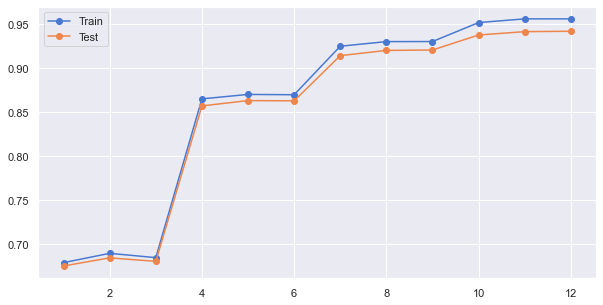

In [211]:
rf = RandomForestRegressor()

parameters= {
    'n_estimators':[5, 50, 100],
    'max_depth':[2, 4 , 6, 8]
}

cv = GridSearchCV(rf, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv) 

In [212]:
rf_best=cv.best_estimator_

# XG Boost Regressor

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}

0.897 (+/-0.017) for {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.913 (+/-0.016) for {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}
0.925 (+/-0.016) for {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.936 (+/-0.013) for {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}
0.94 (+/-0.011) for {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.947 (+/-0.011) for {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}
0.922 (+/-0.014) for {'learning_rate': 0.1,

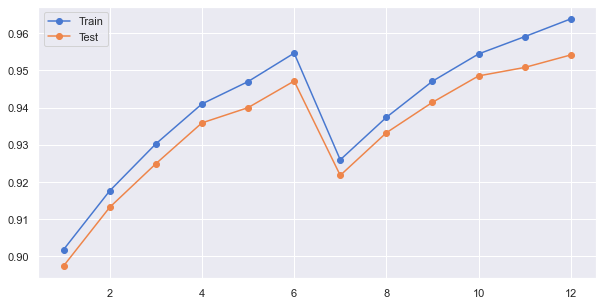

In [213]:
xgb = XGBRegressor()

parameters= {
    "objective": ["reg:squarederror"],
    'n_estimators':[100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [1]
}

cv = GridSearchCV(xgb,parameters , cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv) 

In [214]:
xgb_best = cv.best_estimator_

# Support Vector Regressor

In [215]:
'''svr = SVR()

parameters= {
    'kernel':["linear", "rbf"],
    'C':[0.1, 1, 10, 50, 100, 150]
}

cv = GridSearchCV(svr, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)''' 

'svr = SVR()\n\nparameters= {\n    \'kernel\':["linear", "rbf"],\n    \'C\':[0.1, 1, 10, 50, 100, 150]\n}\n\ncv = GridSearchCV(svr, parameters, cv=5, return_train_score=True)\ncv.fit(tr_features, tr_labels.values.ravel())\n\nprint_results(cv)'

In [216]:
svr_best = cv.best_estimator_

# Multi-Layer Perceptron Regressor

BEST PARAMS: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 1, 'max_iter': 700}

0.915 (+/-0.025) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'learning_rate_init': 1, 'max_iter': 700}
0.921 (+/-0.016) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'learning_rate_init': 1.2, 'max_iter': 700}
0.918 (+/-0.015) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'learning_rate_init': 1.5, 'max_iter': 700}
0.92 (+/-0.031) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 1, 'max_iter': 700}
0.914 (+/-0.023) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 1.2, 'max_iter': 700}
0.925 (+/-0.017) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 1.5, 'm

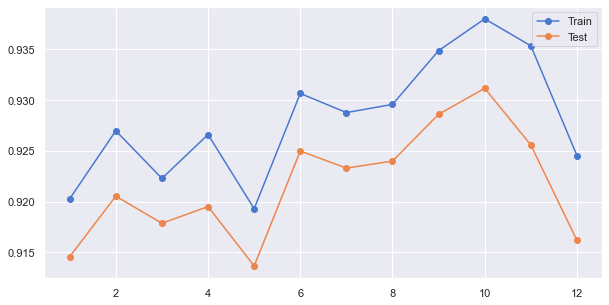

In [217]:
mlp = MLPRegressor()

parameters= {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ["relu"],
    "learning_rate": ["invscaling", "adaptive"],
    "learning_rate_init": [1, 1.2, 1.5],
    "max_iter": [700]
}

cv = GridSearchCV(mlp, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [218]:
mlp_best = cv.best_estimator_

# Gradient Boosting Regressor

BEST PARAMS: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 50}

0.274 (+/-0.011) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.431 (+/-0.014) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}
0.501 (+/-0.021) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.711 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.803 (+/-0.017) for {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
0.862 (+/-0.018) for {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
0.926 (+/-0.014) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.942 (+/-0.012) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.896 (+/-0.012) for {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 50}
0.915 (+/-0.014) for {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 100}
0.942 (+/-0.009) for {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 50}
0.94 (+/-0.014) for {'learning_rate': 1, 'max_

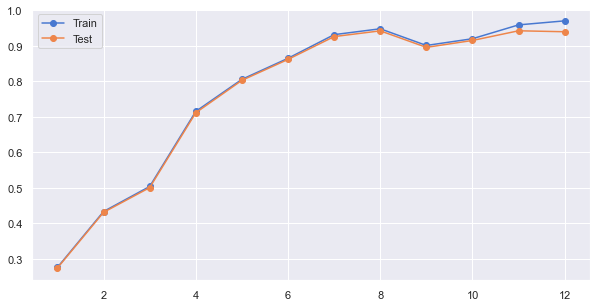

In [219]:
gb = GradientBoostingRegressor()

parameters= {
    'learning_rate':[0.01, 0.1, 1],
    'n_estimators':[50, 100],
    'max_depth':[1, 3]    
}

cv = GridSearchCV(gb, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv) 

In [220]:
gb_best = cv.best_estimator_

# Elastic Net

BEST PARAMS: {'alpha': 0.01, 'l1_ratio': 0.7, 'selection': 'random'}

0.776 (+/-0.018) for {'alpha': 0.001, 'l1_ratio': 0.7, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.001, 'l1_ratio': 0.7, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.001, 'l1_ratio': 0.9, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.001, 'l1_ratio': 0.9, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.01, 'l1_ratio': 0.7, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.01, 'l1_ratio': 0.7, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.01, 'l1_ratio': 0.9, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.01, 'l1_ratio': 0.9, 'selection': 'random'}
0.775 (+/-0.017) for {'alpha': 0.1, 'l1_ratio': 0.7, 'selection': 'cyclic'}
0.775 (+/-0.017) for {'alpha': 0.1, 'l1_ratio': 0.7, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.1, 'l1_ratio': 0.9, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.1, 'l1_ratio': 0.9, 'selection': 'random'}


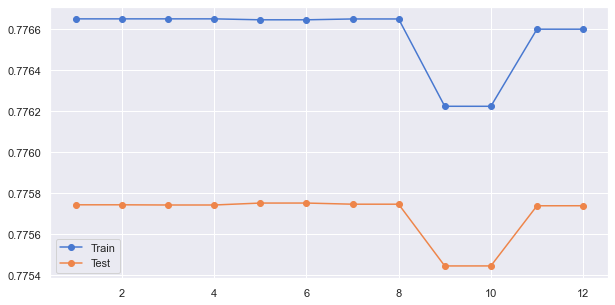

In [221]:
en = ElasticNet()

parameters= {
    "alpha": [0.001, 0.01, 0.1],
    "l1_ratio": [ 0.7, 0.9],
    "selection": ["cyclic", "random"]
}

cv = GridSearchCV(en, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [222]:
en_best = cv.best_estimator_

# Ridge

BEST PARAMS: {'alpha': 0.001, 'normalize': True, 'solver': 'svd'}

0.776 (+/-0.018) for {'alpha': 0.0001, 'normalize': True, 'solver': 'auto'}
0.776 (+/-0.018) for {'alpha': 0.0001, 'normalize': True, 'solver': 'svd'}
0.776 (+/-0.018) for {'alpha': 0.0001, 'normalize': True, 'solver': 'sparse_cg'}
0.776 (+/-0.018) for {'alpha': 0.001, 'normalize': True, 'solver': 'auto'}
0.776 (+/-0.018) for {'alpha': 0.001, 'normalize': True, 'solver': 'svd'}
0.776 (+/-0.018) for {'alpha': 0.001, 'normalize': True, 'solver': 'sparse_cg'}
0.776 (+/-0.018) for {'alpha': 0.01, 'normalize': True, 'solver': 'auto'}
0.776 (+/-0.018) for {'alpha': 0.01, 'normalize': True, 'solver': 'svd'}
0.776 (+/-0.018) for {'alpha': 0.01, 'normalize': True, 'solver': 'sparse_cg'}
0.772 (+/-0.017) for {'alpha': 0.1, 'normalize': True, 'solver': 'auto'}
0.772 (+/-0.017) for {'alpha': 0.1, 'normalize': True, 'solver': 'svd'}
0.772 (+/-0.017) for {'alpha': 0.1, 'normalize': True, 'solver': 'sparse_cg'}


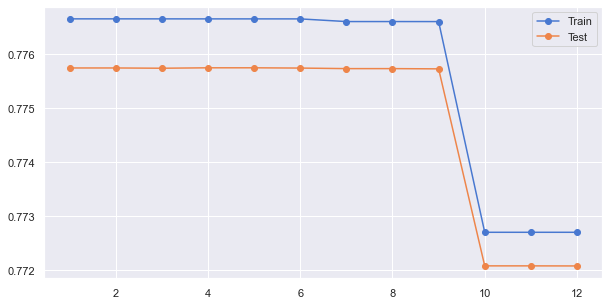

In [223]:
rd = Ridge()

parameters= {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "normalize": [True],
    "solver": ["auto", "svd", "sparse_cg"]
    
}

cv = GridSearchCV(rd, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [224]:
rd_best = cv.best_estimator_

# Lasso

BEST PARAMS: {'alpha': 0.1, 'normalize': True, 'selection': 'random'}

0.776 (+/-0.018) for {'alpha': 1e-05, 'normalize': True, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 1e-05, 'normalize': True, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.001, 'normalize': True, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.001, 'normalize': True, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.01, 'normalize': True, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.01, 'normalize': True, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.1, 'normalize': True, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.1, 'normalize': True, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.25, 'normalize': True, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.25, 'normalize': True, 'selection': 'cyclic'}
0.776 (+/-0.018) for {'alpha': 0.5, 'normalize': True, 'selection': 'random'}
0.776 (+/-0.018) for {'alpha': 0.5, 'normalize': True, 'sel

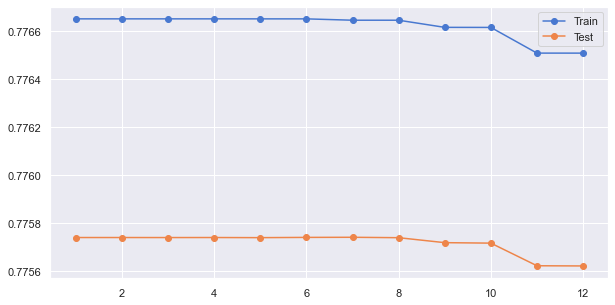

In [225]:
ls = Lasso()

parameters= {
    "alpha": [0.00001, 0.001, 0.01, 0.1, 0.25, 0.5],
    "normalize": [True],
    "selection": ["random", "cyclic"]
}

cv = GridSearchCV(ls, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [ ]:
Lasso()

In [226]:
ls_best = cv.best_estimator_

### Aggregate trained models-Evaluating models on validation set

In [227]:
models= {"RF" : rf_best,
         "XGB": xgb_best,
         "MLP": mlp_best,
         "GB": gb_best,
         "EN": en_best,
         "RD": rd_best,
         "LS": ls_best}
models

{'RF': RandomForestRegressor(max_depth=8),
 'XGB': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'MLP': MLPRegressor(learning_rate='adaptive', learning_rate_init=1, max_iter=700),
 'GB': GradientBoostingRegressor(learning_rate=1, n_estimators=50),
 'EN': ElasticNet(alpha=0.01, l1_ratio=0.7, selection='random'),
 'RD': Ridge(alpha=0.001, normalize=True, solver='svd'),
 'LS': Lasso(alpha=0.1, normalize=True, selection='random')}

In [228]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    
    MAE= round(mean_absolute_error(labels, pred), 3)
    MSE= round(mean_squared_error(labels, pred), 3)
    R2= round(r2_score(labels, pred), 3)
    
    print("{} // MAE: {} // MSE: {} // R2: {} // Latency: {}ms \n".format(name,
                                                                          MAE,
                                                                          MSE,
                                                                          R2,
                                                                          round((end - start), 3)))

In [229]:
for name, mdl in models.items():
    evaluate_model(name, mdl, val_features, val_labels)

RF // MAE: 1914.57 // MSE: 8142014.647 // R2: 0.938 // Latency: 0.023ms 

XGB // MAE: 1681.867 // MSE: 6737806.014 // R2: 0.948 // Latency: 0.01ms 

MLP // MAE: 1954.797 // MSE: 8497102.761 // R2: 0.935 // Latency: 0.004ms 

GB // MAE: 1822.054 // MSE: 7680349.335 // R2: 0.941 // Latency: 0.002ms 

EN // MAE: 3704.974 // MSE: 28610352.313 // R2: 0.781 // Latency: 0.0ms 

RD // MAE: 3705.548 // MSE: 28595240.841 // R2: 0.781 // Latency: 0.001ms 

LS // MAE: 3704.596 // MSE: 28604589.871 // R2: 0.781 // Latency: 0.0ms 



# Evaluate best model on test set

In [230]:
evaluate_model("XGBoost Regressor", models["XGB"], te_features, te_labels)

XGBoost Regressor // MAE: 1647.482 // MSE: 5601416.496 // R2: 0.958 // Latency: 0.006ms 

